

Advanced Project I

Student: Daniel Alejandro Córdoba Valencia

This notebook is intended for the volumetric reconstruction of the geometry of 3D microscopic samples using the hologram obtained from an off axis digital holografic microscope in transmission configuration with a microscope objective in telecentric configuration for magnification.

The first step of the process after obtaining the interferogram of the sample with a reference wave is applying a spatial filter and phase compensation to get rid of the reference wave in order to obtain the hologram of the sample. This process is described by the following expresion.

$$
  T(x, y) = |O(x, y) + R(x, y)|^2 = |O(x, y)|^2 + |R|^2 + O^*(x, y)R(x, y) + O(x, y)R^*(x, y)
$$



In [2]:
'''Importing the necessary libraries for the whole code'''
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from skimage.util import view_as_windows
from matplotlib.animation import FuncAnimation


The following code section contains a function by Sofia Obando, et al. that performs the spatial filter and phase compensation and returns the complex optical plane $O(x, y)$ at $z=0$.

In [3]:

'''Semi-Heuristic Phase Compensation function

  Authors: Sofia Obando-Vasquez(1), Ana Doblas (2) and Carlos trujillo (1)
  Date: 08-04-2023

  Python Adaptation: Daniel Córdoba (1)

  (1) Universidad EAFIT, Medellin, Colombia
  (2) The University of Memphis, Memphis, TN, United States

  read function:
    Inputs:
      filename: name of the file of the hologram
      path: path of the file of the hologram

    Outputs:
      holo: ndarray with the information of the image.

  compensate function:
    Inputs:
      hologram: ndarray with the input hologram
      dx,dy: pixel pitch of the digital sensor in each direction
      lambda_: wavelenght of the register
      region: for the spatial, one must select in which region of the Fourier
      spectrum want to perform the spatial filter. Asigne a value of 1-4
      according to the cartessian regions of a plane.
      step: value of the step for each iteration of the search
      G: value of the depth of the search

    Outputs:
      phase: the phase reconstruction of the hologram

  save function:
    Inputs:
      hologram: ndarray of the compensated hologram
      outname: name of the output file
      path: path of the output file
      ext: extension of teh output file
      cmap: colormap object to be applied to the output image

    Outputs:
      None


'''

def read(filename:str, path:str = '') -> np.ndarray:
    '''Reads image to double precision 2D array.'''

    if path!='':
        prefix = path + '\x5c'
    else:
        prefix = ''

    holo = plt.imread(prefix + filename).astype(np.float64)

    if len(np.shape(holo)) > 2:
        # If the image is RGB, use only one channel (assume grayscale image)
        holo = holo[:,:,0]

    return holo


def filter_mask(holo:np.ndarray,
                N:int,
                M:int,
                region:int) -> tuple[np.ndarray, np.float64]:
    '''Applies broad filter to eliminate unwanted dc signal.

    returns the filtered ft of the hologram and the index of its max value.
    '''

    #Calculate the Fourier Transform of the hologram and shift the
    #zero-frequency component to the center
    ft_holo = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(holo)))


    filter_ = np.zeros((N, M))

    # Create a filter mask for the desired region
    if region==1:
        filter_[0:round(N/2-(N*0.1)),round(M/2+(M*0.1)):M] = 1; # 1st quadrant
    elif region==2:
        filter_[0:round(N/2-(N*0.1)),0:round(M/2-(M*0.1))] = 1; # 2nd quadrant
    elif region==3:
        filter_[round(N/2+(N*0.1)):N,0:round(M/2-(M*0.1))] = 1; # 3rd quadrant
    else:
        filter_[round(N/2+(N*0.1)):N,round(M/2+(M*0.1)):M] = 1; # 4th quadrant

    # Apply the filter to the Fourier Transform of the hologram
    ft_filtered_holo = ft_holo * filter_

    filtered_spect = np.log(np.abs(ft_filtered_holo)**2+1)
    # Find the maximum value in the filtered spectrum

    idx = np.argmax(filtered_spect, axis=None)
    return ft_filtered_holo, idx


def normalize(x: np.ndarray, scale: float) -> np.ndarray:
    '''Normalize every value of an array to the 0-scale interval.'''

    return scale*(x-np.min(x))/(np.max(x)-np.min(x))


def metric( holo_rec:np.ndarray,
            fx_0:int,
            fy_0:int,
            fx_tmp:int,
            fy_tmp:int,
            lambda_:float,
            M:int,
            N:int,
            dx:float,
            dy:float,
            m:np.ndarray,
            n:np.ndarray,
            k:float) -> float:
    '''Function to reduce cluster in the compensation function.'''

    #Calculate the angles for the compensation wave
    theta_x = np.arcsin((fx_0 - fx_tmp) * lambda_ / (M * dx))
    theta_y = np.arcsin((fy_0 - fy_tmp) * lambda_ / (N * dy))

    #Calculate the reference wave
    ref = np.exp(1j * k * (np.sin(theta_x) * m * dx + np.sin(theta_y) * n * dy))

    #Apply the reference wave to the hologram reconstruction (elementwise)
    holo_rec2 = holo_rec * ref

    #Calculate the phase of the hologram reconstruction
    phase = np.angle(holo_rec2)

    #Normalize the phase
    phase = normalize(phase, 1)

    # Threshold the phase image (binarization)
    BW = np.where(phase>0.1, 1, 0)

    #Calculate the sum of all elements in the resulting binary image
    num = np.sum(BW)

    return num

def compensate(hologram:np.ndarray,
               dx:float, dy:float,
               lambda_:float,
               region:int,
               step:float = 0.5,
               depth:int = 3) -> np.ndarray:
    '''Filters and compensates the input hologram.'''
    N, M = np.shape(hologram)[:2]

    mm, nn = np.linspace(-M/2, M/2-1, M), np.linspace(-N/2, N/2-1, N)


    m, n = np.meshgrid(mm, nn)

    ft_filtered_holo, idx = filter_mask(hologram, N, M, region)

    # Define wavenumber
    k = 2 * np.pi / lambda_

    # Calculate the center frequencies for fx and fy
    fx_0 = M/2
    fy_0 = N/2

    # Get the maximum values of fx and fy
    fy_max, fx_max = np.unravel_index(idx, [N, M])


    # Define the step size for the search
    step = step

    # Initialize variables for the search
    j = 0

    # Calculate the Inverse Fourier Transform of the filtered hologram
    holo_rec = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ft_filtered_holo)))

    # Define the search range (G)
    G = depth

    # Initialize flag for the search loop
    fin = 0

    # Set initial values for fx and fy
    fx = fx_max
    fy = fy_max

    # Initialize temporary search range
    G_temp = G

    # Loop to find the optimal fx and fy values
    while fin == 0:
        i = 0
        j = j + 1

        # Initialize the maximum sum (for thresholding)
        suma_maxima=0

        # Nested loops for searching in the range of fx and fy
        for fy_tmp in np.arange(fy-step*G_temp, fy+step*G_temp, step):
            for  fx_tmp in np.arange(fx-step*G_temp, fx+step*G_temp, step):

                i = i+1

                # Calculate the metric for the current fx and fy
                suma = metric(holo_rec, fx_0, fy_0, fx_tmp, fy_tmp,
                              lambda_, M, N , dx, dy, m, n, k)

                # Update maximum sum and corresponding fx and fy if
                # current sum is greater than the previous maximum
                if suma > suma_maxima:
                    x_max_out = fx_tmp
                    y_max_out = fy_tmp
                    suma_maxima = suma

        # Update the temporary search range
        G_temp = G_temp - 1

        # Check if the optimal values are found, set the flag to exit the loop
        if (x_max_out == fx) and (y_max_out == fy):
            fin = 1;


        # Update fx and fy for the next iteration
        fx = x_max_out
        fy = y_max_out


    # Calculate the angles for the compensation wave
    theta_x = np.arcsin((fx_0 - x_max_out) * lambda_ / (M * dx))
    theta_y = np.arcsin((fy_0 - y_max_out) * lambda_ / (N * dy))

    # Calculate the reference wave
    ref = np.exp(1j * k * (np.sin(theta_x) * m * dx + np.sin(theta_y) * n * dy))

    # Apply the reference wave to the hologram reconstruction
    holo_rec2 = holo_rec * ref


    return holo_rec2


def save(hologram:np.ndarray,
         outname:str, path:str = '',
         ext:str = 'bmp',
         cmap:str = 'gray') -> None:
    '''Function to save the hologram to a file'''
    CompA = np.abs(hologram)
    CompP = np.angle(hologram)

    # Normalize the phase and convert it to uint8
    CompP = normalize(CompP, 255).astype(np.uint8)

    # Normalize the amplitude and convert it to uint8
    CompA = normalize(CompA, 255).astype(np.uint8)

    # Save the phase image
    if path!='':
        prefix = path + '\x5c'
    else:
        prefix = ''

    plt.imsave(prefix + outname + '-Phase' + '.' + ext, CompP, cmap=cmap)

    # Save the phase image
    plt.imsave(prefix + outname + '-Amplitude' + '.' + ext, CompA, cmap=cmap)

In order to propagate the hologram's optical field, one can utilize the angular spectrum propagation method. This method uses the Helmholtz equation to express the angular spectrum of a complex field at an arbitrary distance in terms of a known complex field.

The angular spectrum of a wave field is defined as follows

$$
  A(f_x, f_y; 0) = FT(U(x, y, 0))
$$

Where $FT$ refers to the Fourier transform of the wave field. Propagating this expression using the Helmholtz equation yields the following expression:

$$
  U(x, y, z) = FT^{-1}(A(f_x, f_y, 0)H(f_x, f_y; z))
$$

Where $H$ is defined as the angular spectrum propagation kernel.

$$
  H(f_x, f_y, z) = \iint_{-\infty}^\infty e^{-i2\pi zG\sqrt{\frac{1}{\lambda^2} - f_x^2 - f_y^2}} df_x df_y
$$

In this case, $G$ refers to the image magnification, since the sample needs to be magnified in order to be captured by a camera and the propagation distance is proportional to this magnification.

In the discrete case, one can use the fast fourier transform (fft), however, one must correctly define the scope of the spatial frequencies. Using the size of the image in pixels $(N, M)$, and the measure of each pixel in meters $(\Delta x, \Delta y)$, the spatial frequencies satisfy the following expression:

$$
  f_x' = \frac{f_x}{N\Delta x}, -N/2 < f_x < N/2
$$

The same can be said about $f_y$.



In [4]:
def propagate(U: np.array,
              z: float,
              lmbda: float,
              dx:float,
              dy:float,
              scale_factor = 1) -> np.ndarray:
  ''' Function to propagate a scalar wave field with its angular spectrum
  Inputs:
    U: matrix containing the input image array
    z: propagated distance
    lmbda: wavelength
    dx,dy: pixel pitch of the digital sensor in each direction
    scale_factor: magnification of the optical system

  Outputs:
    Uz_complex: Propagated complex field
  '''

  # Getting the shape of the input field
  N, M = np.shape(U)[:2]

  #Creating a meshgrid with the correct spatial coordinates
  mm, nn = np.linspace(-M/2, M/2-1, M), np.linspace(-N/2, N/2-1, N)

  m, n = np.meshgrid(mm, nn)

  #angular spectrum of the image at the origin
  A = np.fft.fft2(U)

  kernel = np.exp(-1j * 2 * np.pi * z * scale_factor *
                  np.sqrt((1/(lmbda**2)) - (m/(M*dx))**2 - (n/(N*dy))**2 + 0j))


  #optical field at z
  Uz_complex = np.fft.ifft2(A*np.fft.fftshift(kernel))

  return Uz_complex

One of the ways to measure focus locally is measuring the variance of a portion of the input image and composing the result of the variance in a new image. These portions can intercept with each other.

Another measure that can be used to map focus or edges in images is the acutance, which is defined as the gradient of the density of the image.

$$
  A = \nabla D
$$

This density can be interpreted as the intensity of the image in each pixel, so one can directly obtain the acutance just computing the gradient of the image. The gradient can be adjusted to compute a gaussian mean over the local region with some standard deviation.




In [5]:
def focus_variance(U: np.ndarray, S: int=3) -> np.ndarray:
    """Calculates the local variance of an array.

    Inputs:
        U: The input array.
        S: The size of the kernel to use for calculating the variance.

    Returns:
        variances: ndarray containing the local variance of the input array.
    """

    # Create a view of the array as a set of overlapping windows
    windows = view_as_windows(np.abs(U), window_shape=(S, S), step=1)

    # Calculate the variance of each window
    variances = np.var(windows, axis=(2, 3))

    return variances

def focus_acutance(U:np.ndarray, sigma:int = 1) -> np.ndarray:
    """Calculates the local level of focus of a complex optical plane.

    Inputs:
        U: The complex optical plane.
        sigma: maximum standard deviation of the gradient field

    Outputs:
        acutance: map of acutance of the input array
    """

    acutance = sc.ndimage.gaussian_gradient_magnitude(np.abs(U), sigma=sigma)



    return acutance

It is useful as well to have a global metric of the focus of the image. Simply the variance of the whole dataset can be useful, as well of the mean acutance.

In [6]:
def metric_variance(U:np.ndarray) -> float:
  '''returns the variance of a complex array'''

  return np.var(np.abs(U))

def metric_acutance(U:np.ndarray, sigma: float) -> float:
  '''Returns the mean acutance of a complex array'''

  acutance = sc.ndimage.gaussian_gradient_magnitude(np.abs(U), sigma=sigma)

  return np.mean(acutance)

In [7]:
def focus3D(U:np.ndarray,
            dz:float,
            lmbda:float,
            dx:float,
            dy:float,
            S:int,
            n:int,
            scale_factor:float=1,
            method:str = 'acutance') -> list[tuple]:
  """Calculates the local level of focus of a complex optical plane
  at different propagation distances.

  Inputs:
      U: The complex optical plane.
      dz: The propagation step size.
      lmbda: The wavelength of light.
      dx: The horizontal pitch of the input plane.
      dy: The vertical pitch of the input plane.
      S: The number of subsections to divide the plane into.
      n: The number of propagation steps.

  Outputs:
      focuss: list containing 1) acutance, 2) distance of propagation and
      3) complex field; at each step of propagation.
  """

  focuss = []

  for i in range(n):
    U_prop = propagate(U, -n*dz/2 + dz*i, lmbda, dx, dy,
                       scale_factor=scale_factor)

    focuss.append((focus_acutance(U_prop, S),
                          -n*dz/2 + dz*i,
                          U_prop))

  return focuss



In [8]:
def prop_focus(U:np.ndarray, lambda_:float, dx:float,
               dy:float, min_z:float, max_z:float,
               steps:float, scale_factor:float = 1, sigma:float = 1) -> float:

  range_ = np.linspace(min_z, max_z, steps)

  metrics = []
  fields = []

  for z in range_:
    G = propagate(U, z, lambda_, dx, dy, scale_factor)
    metrics.append(metric_variance(G))
    fields.append(G)
    #metrics.append(metric_acutance(G, sigma))
    #metrics.append(np.max(focus_variance(U)))


  metrics = np.array(metrics)

  #Variance is low for focused translucent samples and high for focused opaque samples
  min_focus = np.min(metrics)
  min_ind = np.argmin(metrics)
  return fields[min_ind], range_[min_ind], metrics




In [9]:
path = "C:/Users/dacv0/Documents/Codigo/Python/avanzado 1/"


# Parameters
dx, dy = 3.5, 3.5 #um
region = 1
lambda_ = 0.633 #um

grab = read(path +'40X/' + 'holo_ESP_165.bmp')
holo = compensate(grab, dx, dy, lambda_, region, step=0.5, depth=3)
save(holo, 'filtrado', path=path+'resultados/', ext='png')



In [10]:
z = 250 #um

prop = propagate(holo, z, lambda_, dx, dy, scale_factor=40)

#save(prop, f'filtrado+{z}um', path=path+'resultados/', ext='png')

In [11]:
focusvar = focus_variance(prop)
focusacu = focus_acutance(prop)

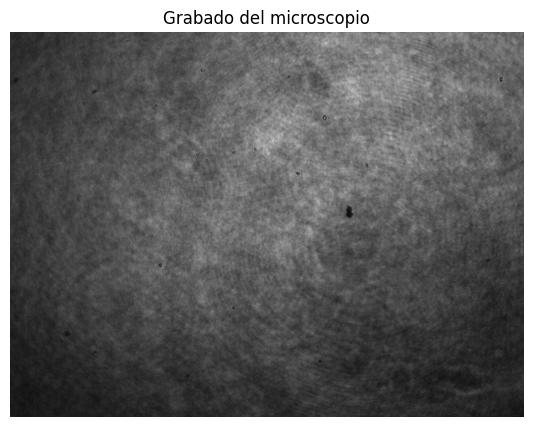

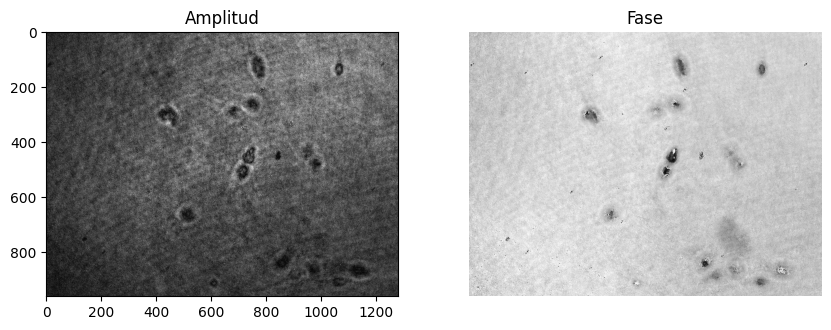

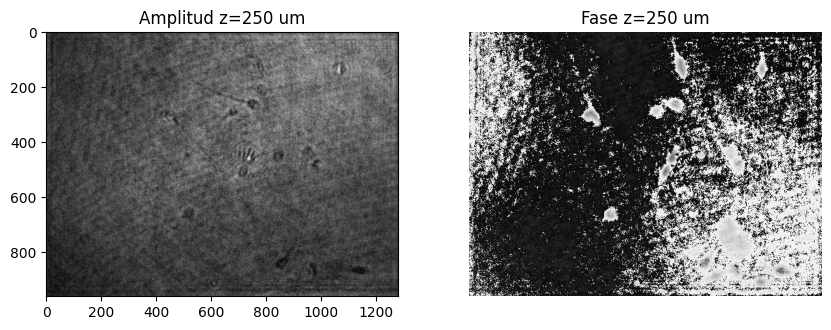

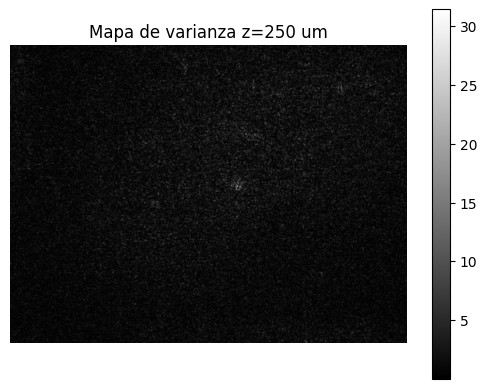

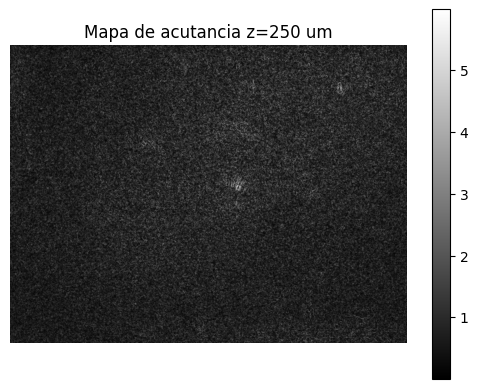

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.imshow(np.abs(grab), cmap='gray')
axes.set_title('Grabado del microscopio')
plt.axis('off')


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.axis('off')

axes[0].imshow(np.abs(holo), cmap='gray')
axes[0].set_title('Amplitud')

axes[1].imshow(np.angle(holo), cmap='gray')
axes[1].set_title('Fase')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.axis('off')

axes[0].imshow(np.abs(prop), cmap='gray')
axes[0].set_title(f'Amplitud z={z} um')

axes[1].imshow(np.angle(prop), cmap='gray')
axes[1].set_title(f'Fase z={z} um')


plt.figure()
foc1 = plt.imshow(focusvar, cmap='gray')
plt.title(f'Mapa de varianza z={z} um')
plt.axis('off')


plt.colorbar(foc1)

plt.figure()
foc2 = plt.imshow(focusacu, cmap='gray')
plt.title(f'Mapa de acutancia z={z} um')
plt.axis('off')


plt.colorbar(foc2)
plt.show()


In [13]:
focall = focus3D(holo, 5, lambda_, dx, dy, 3, 100, scale_factor=40)

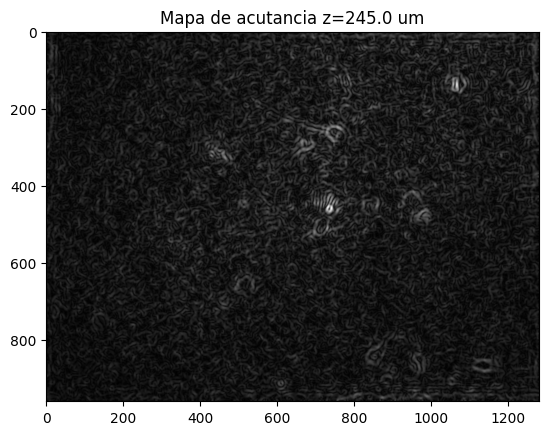

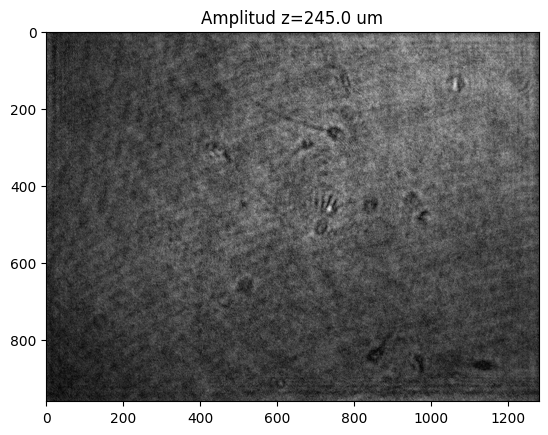

In [14]:


fig, ax = plt.subplots()

def animate(i):
    im, z_, _ = focall[i]
    ax.clear()
    ax.imshow(im, cmap='gray')
    ax.set_title(f'Mapa de acutancia z={z_} um')

anim = FuncAnimation(fig, animate, frames=len(focall), interval=100)

anim.save('focus.gif', dpi=150, writer='pillow')
plt.show()

fig, ax = plt.subplots()

def animate(i):
    _, z_, im = focall[i]
    ax.clear()
    ax.imshow(np.abs(im), cmap='gray')
    ax.set_title(f'Amplitud z={z_} um')

anim = FuncAnimation(fig, animate, frames=len(focall), interval=100)

anim.save('absfield.gif', dpi=150, writer='pillow')
plt.show()





The next section aims to see if one can differentiate the elements of the image using the phase image whose elements are sharply focused. After that, one would try to split the image into sub-images in order to get the one with the most focus and thus finding the positions of all the elements in the image

5
0.14764605770051142
[[ 454.09583661  737.5145326 ]
 [ 840.40354767  854.66518847]
 [ 137.82271468 1062.8033241 ]
 [ 300.54613936  439.6873823 ]
 [ 116.09701493  765.80223881]
 [ 909.14785992 1054.43579767]
 [ 661.74269006  511.95321637]
 [ 939.           64.66666667]
 [ 266.01058201  746.23280423]
 [ 125.35         28.4       ]
 [ 916.13333333  602.        ]
 [ 508.31446541  715.17610063]
 [ 454.09836066  841.04918033]
 [ 574.33333333 1185.33333333]
 [ 755.12        137.96      ]
 [ 124.         1217.81818182]
 [ 138.48805461  772.42320819]
 [ 875.35714286  940.66666667]
 [ 479.5         977.41666667]
 [ 867.52542373 1135.38983051]]


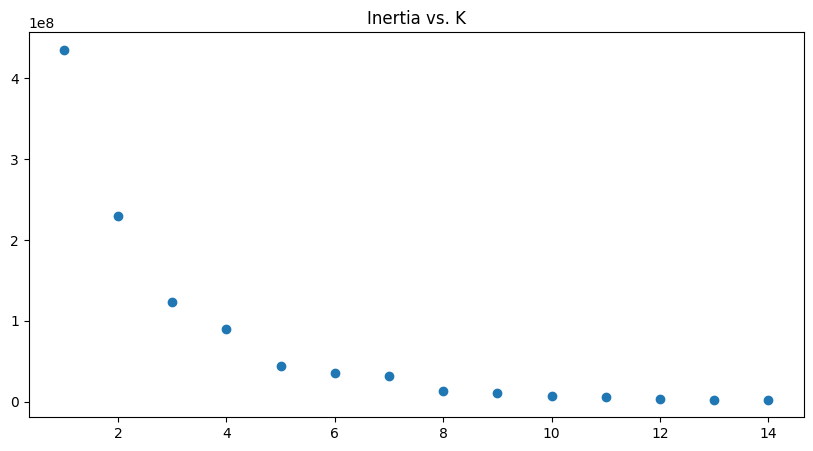

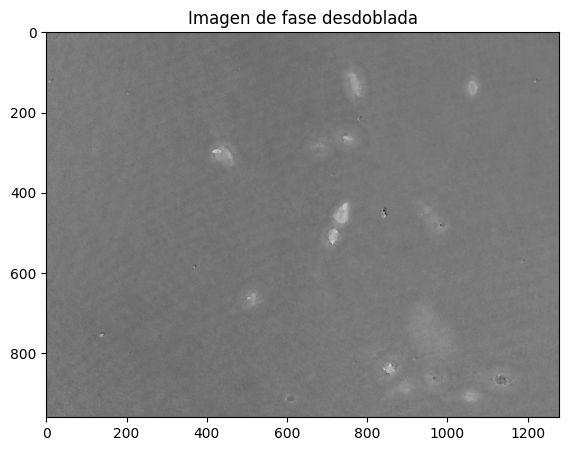

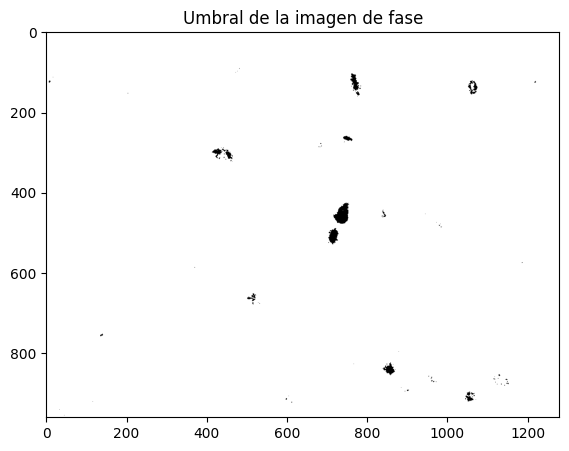

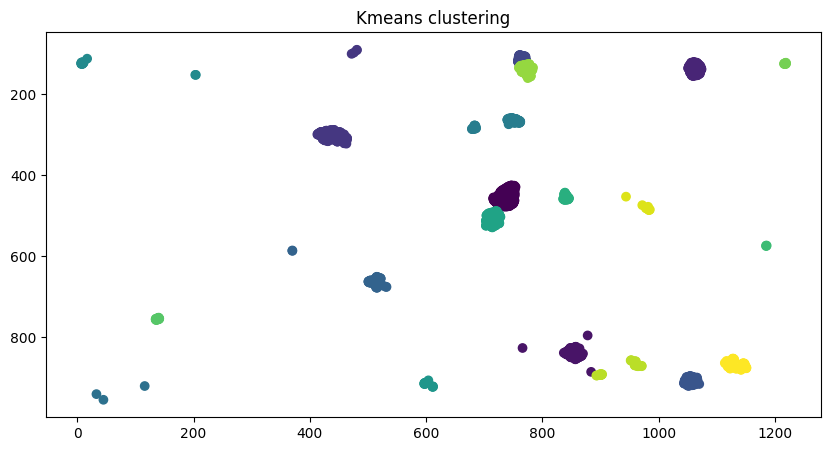

In [17]:
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
from skimage.restoration import unwrap_phase
from kneed import KneeLocator



def cluster(U: np.ndarray, size_mult: float=1) -> list:
  #Calculate the phase of the hologram reconstruction
    phase = np.angle(U)

    #Unwraps the phase so it doesn't have sudden jumps
    phase = unwrap_phase(phase)
    phase = normalize(phase, 1)
    
    # This thresholding doesn't work yet, it is a hardcoded value for now
    threshold = 0.4 #threshold_otsu(phase)
    BW = phase > threshold

    #Converting the image to an array of points for kmeans to cluster
    vals = np.where(BW == [0])
    vals = np.column_stack(vals)

    #Determining the optimal number of clusters, it doesn't work very well so the value is hardcoded for now
    sum_squared_dist = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k, random_state=0)
        km = km.fit(vals)
        sum_squared_dist.append(km.inertia_)

    x = range(1, 15)
    kn = KneeLocator(x, sum_squared_dist, curve='convex', direction='decreasing')

    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.scatter(x, sum_squared_dist)
    axes.set_title('Inertia vs. K')

    print(kn.knee)

    #Calculate the clusters (n_clusters should ideally be kn.knee)
    clust = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(vals)

    # blobs = blob_doh(phase, threshold=0.002)
    # blobs = np.array(blobs)

    return BW, vals, clust.labels_, clust.cluster_centers_

BW, vals, col, centers = cluster(holo)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.imshow(np.ones(holo.shape) - normalize(unwrap_phase(np.angle(holo)), 1), cmap='gray')
axes.set_title('Imagen de fase desdoblada')

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.imshow(BW, cmap='gray')
axes.set_title('Umbral de la imagen de fase')

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.scatter(vals[:, 1], vals[:, 0], c=col)
plt.gca().invert_yaxis()
axes.set_title('Kmeans clustering')

print((np.ones(holo.shape) - normalize((np.angle(holo)), 1))[450, 450])

print(centers)

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# axes.scatter(blobs[:, 1], blobs[:, 0])
# plt.gca().invert_yaxis()
# axes.set_title('Detección DOH')




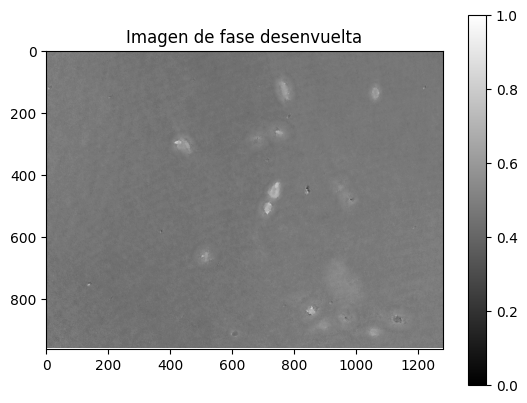

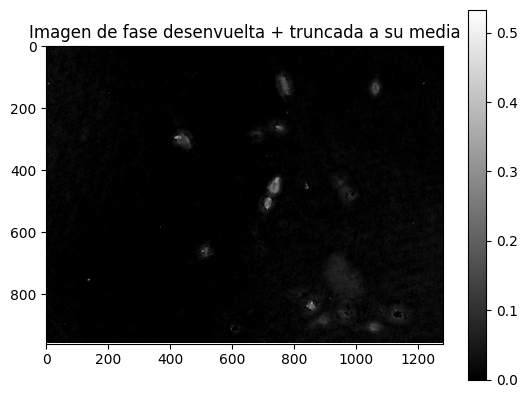

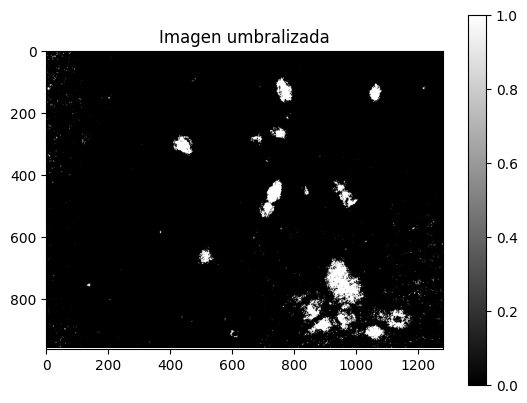

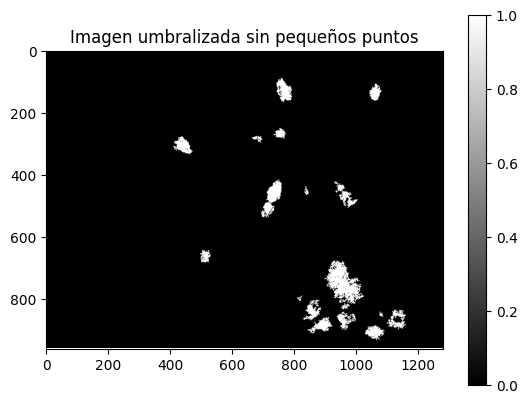

In [46]:
from skimage.filters import threshold_otsu
from skimage import morphology


normal = normalize(unwrap_phase(np.angle(holo)), 1)

mean = np.mean(normal)
imean = np.mean(np.ones(normal.shape) - normal)

max = np.max(normal)
imax = np.max(np.ones(normal.shape)-normal)

sample = None

# Decides to either invert the image or not based on which version's maximum value is 
# the furthest from it's mean, which generally means that the version contains
# the brightest points
if (max-mean)<(imax-imean):
    sample = np.ones(normal.shape) - normal
else:
    sample = normal


plt.figure()
plt.imshow(sample, cmap='gray')
plt.title('Imagen de fase desenvuelta')
plt.colorbar()


# Get's rid of the portion of the image less bright than the mean of the whole image
trunc = sample - np.ones(sample.shape)*np.mean(sample)

filter = trunc < 0
trunc[filter] = 0


plt.figure()
plt.imshow(trunc, cmap='gray')
plt.title('Imagen de fase desenvuelta + truncada a su media')
plt.colorbar()

threshold = threshold_otsu(trunc)
th = trunc>threshold
plt.figure()
plt.imshow(th, cmap='gray')
plt.title('Imagen umbralizada')
plt.colorbar()

# Remove small blobs
th_cleaned = morphology.remove_small_objects(th, min_size=100)

plt.figure()
plt.imshow(th_cleaned, cmap='gray')
plt.title('Imagen umbralizada sin pequeños puntos')
plt.colorbar()
plt.show()



C:\Users\dacv0\AppData\Local\Temp\ipykernel_9220\3455675566.py:20: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes.imshow(np.abs(i), cmap='gray')
C:\Users\dacv0\AppData\Local\Temp\ipykernel_9220\3455675566.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 1, figsize=(10, 5))


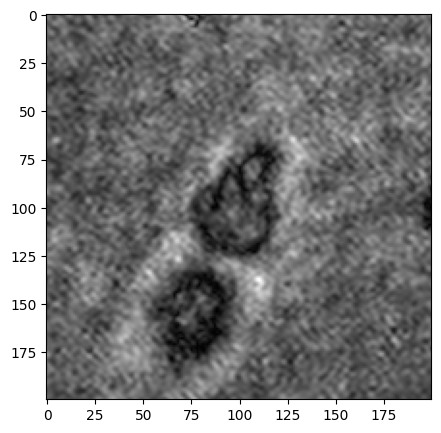

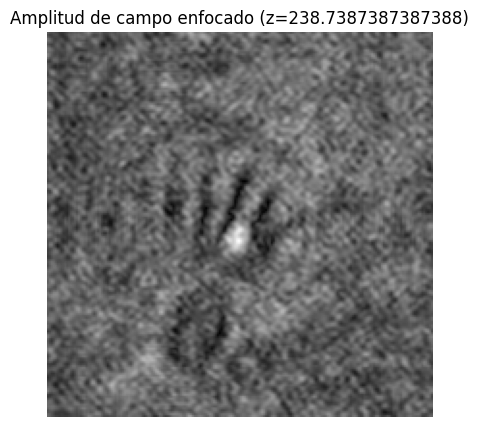

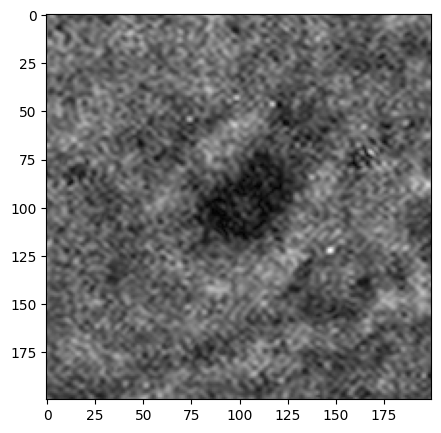

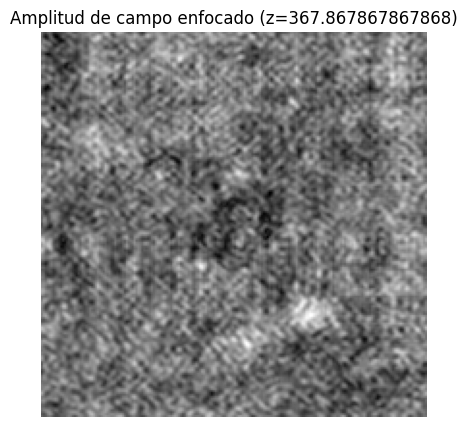

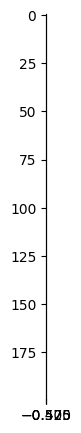

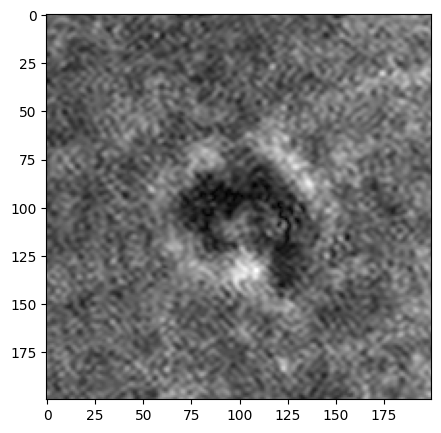

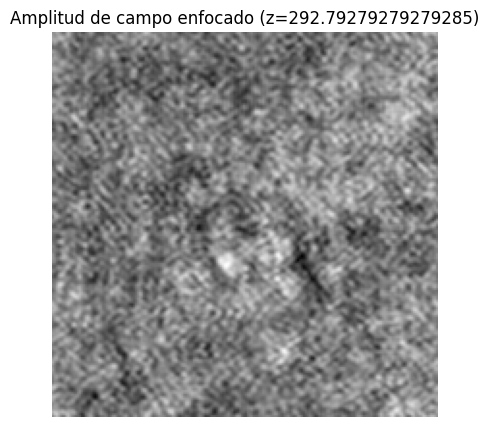

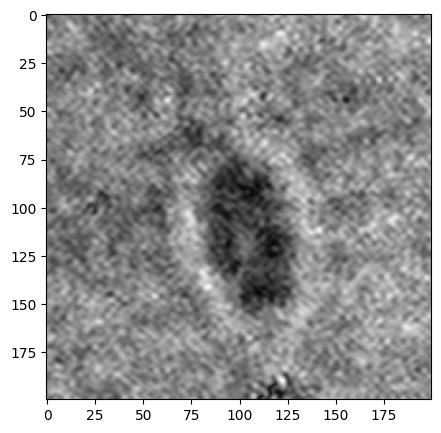

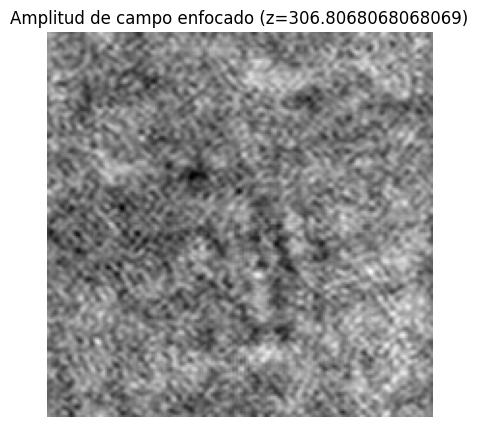

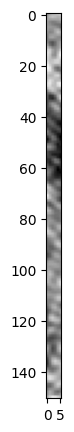

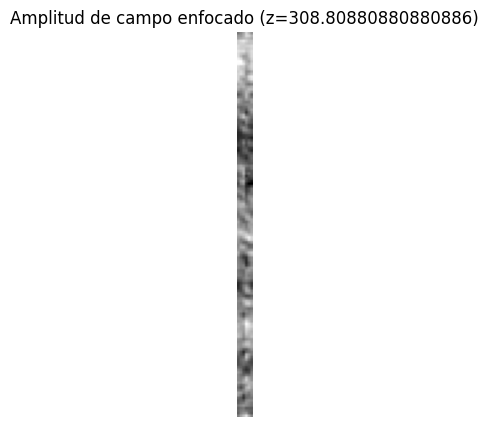

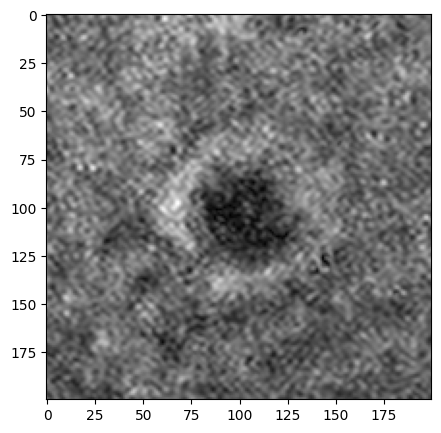

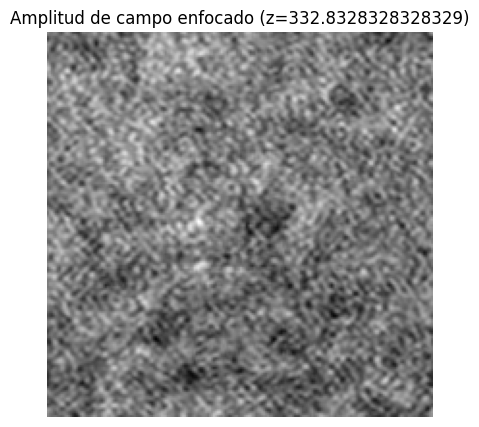

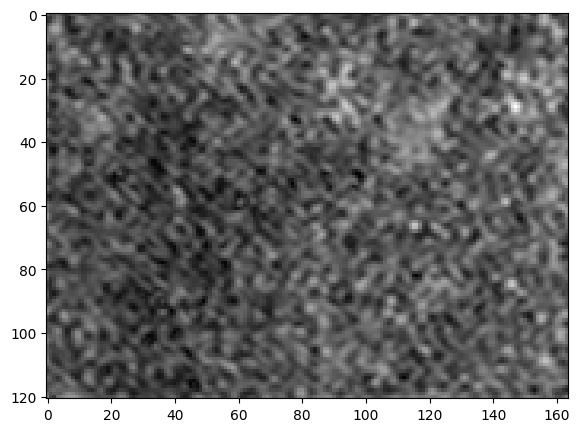

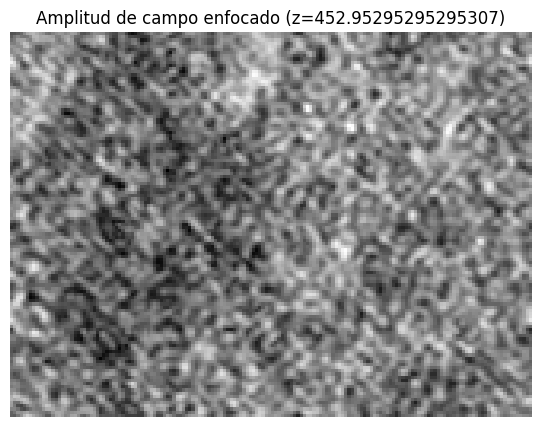

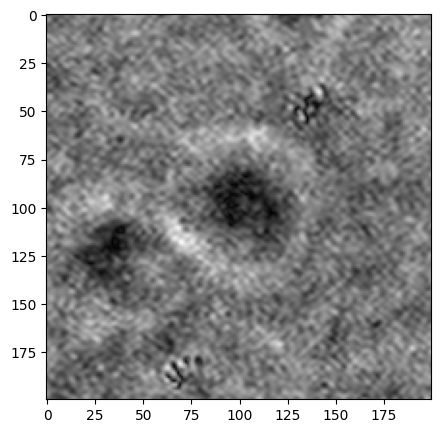

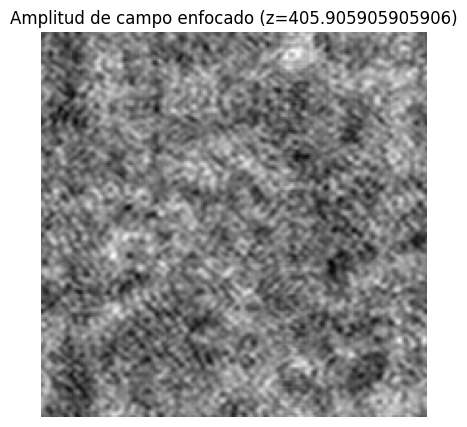

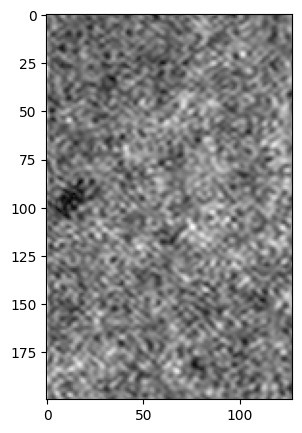

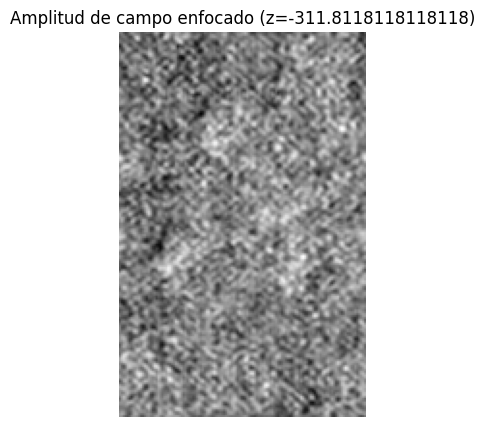

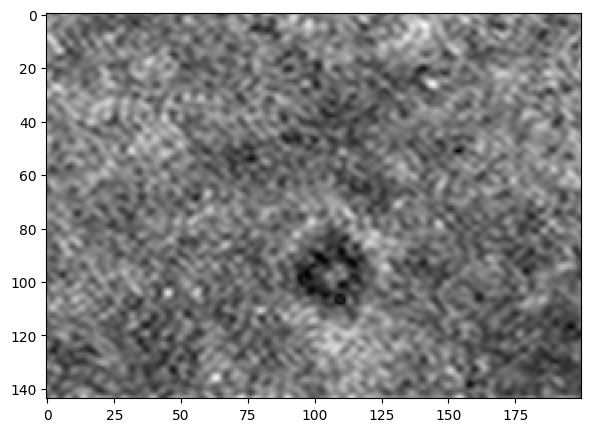

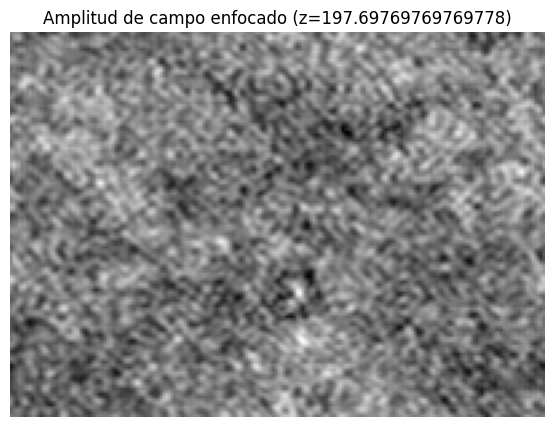

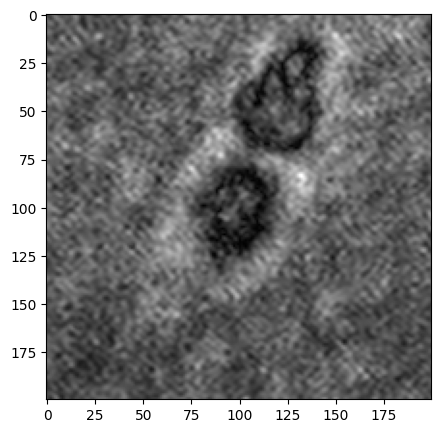

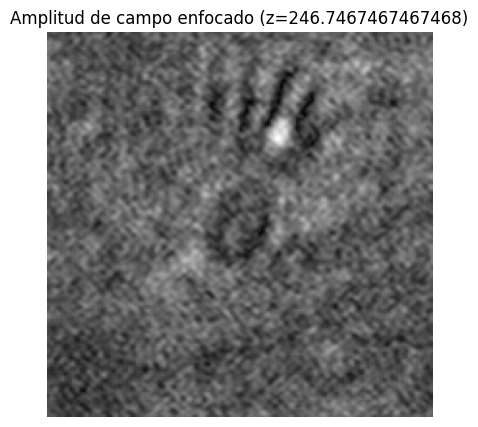

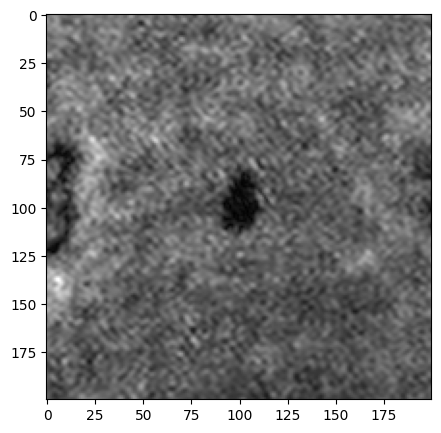

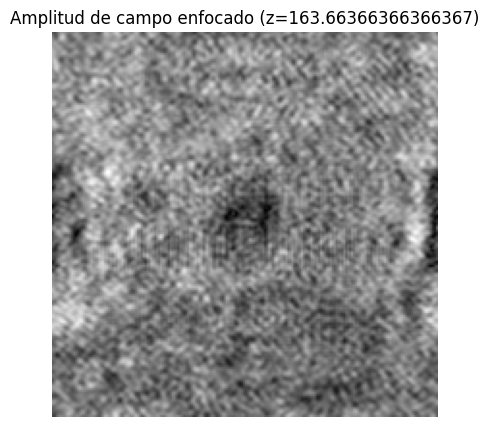

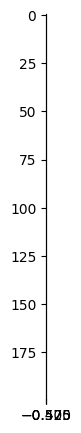

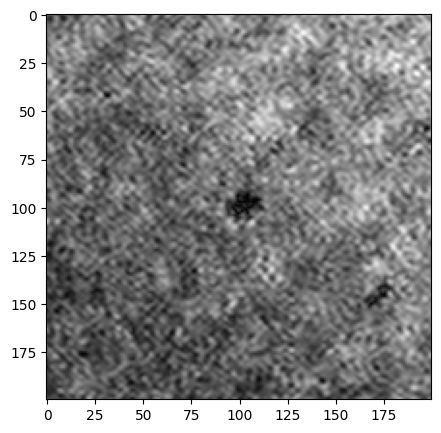

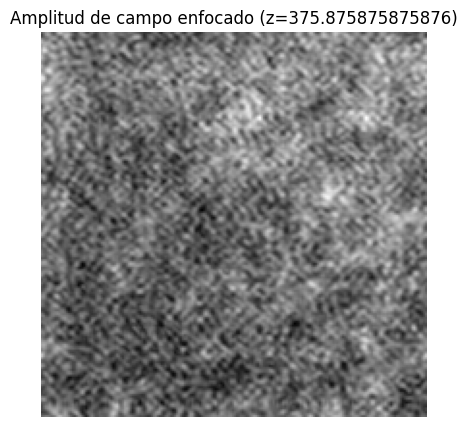

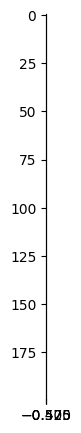

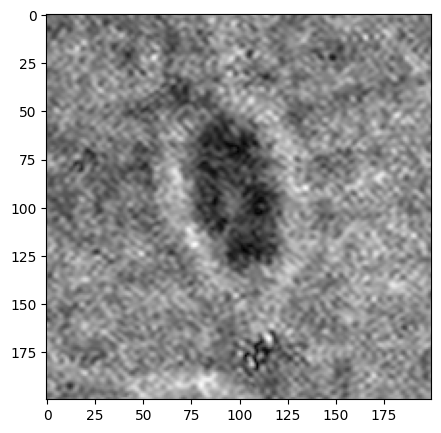

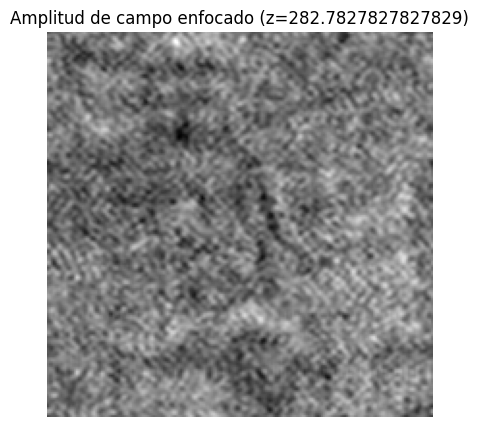

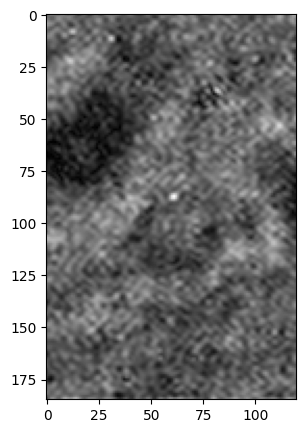

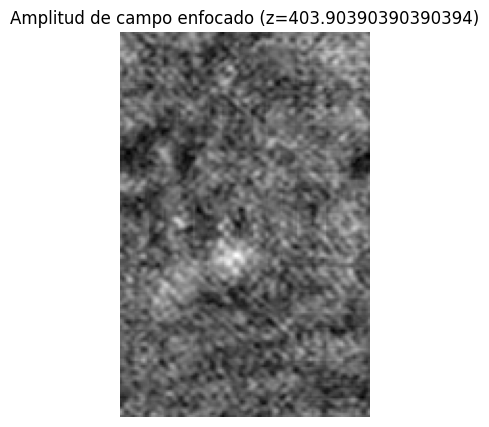

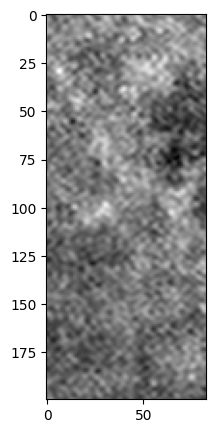

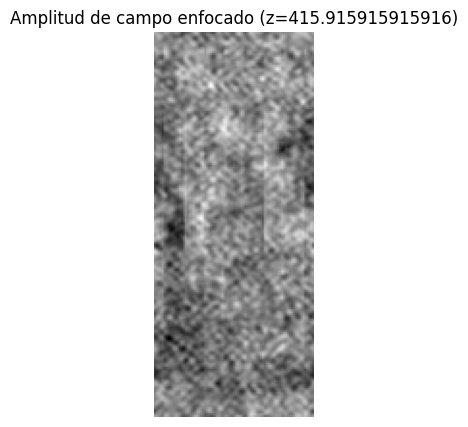

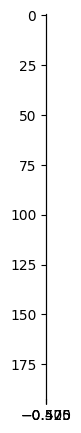

In [19]:

#Once one identifies the custers, the idea would be to extract sub images (windows) from the 
#amplitude image and focus each one separately

def window_extraction(image, centers, window_size) -> list:
  sub_images = []

  for center in centers:
      xleft, xright = max(int(center[0]-window_size/2), 0), min(int(center[0]+window_size/2), image.shape[1])
      yup, ydown = max(int(center[1]-window_size/2), 0), min(int(center[1]+window_size/2), image.shape[0])

      window = image[xleft:xright, yup:ydown]
      sub_images.append(window)

  return sub_images

sub = window_extraction(holo, centers, 200)

for i in sub:
  fig, axes = plt.subplots(1, 1, figsize=(10, 5))
  axes.imshow(np.abs(i), cmap='gray')

  #The try except structure is used to ignore the images that were too short in one dimension because of the limited image size
  try:
    #The range of propagation here is hardcoded
    prop_foc, distances, metrics = prop_focus(i, lambda_, dx, dy, -500, 500, 1000, 40, 3)
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.imshow(np.abs(prop_foc), cmap='gray')
    axes.set_title(f'Amplitud de campo enfocado (z={distances})')
    plt.axis('off')
  except:
    continue


In order to be able to know if these results are accurate or not, it should be tested with simulated holograms. For this, the first step is to create a pure phase object image of a sphere. Then one in another plane. The sum of these two is the perfect simulated sample to know if the method is accurate.


In [20]:
def phase_sphere(imsize, radius, pos, z, lambda_, dxy, scale_factor):
   '''Generates a complex array with a pure phase hemisphere.

   It generates a unitary amplitude - pure phase image of a hemisphere with a certain radius
   The phase image is numerically propagated to a certain z distance with angular spectrum
   '''

   M, N = imsize

   angle = np.ones((N, M))
   amplitude = np.ones((N, M))

   for x in range(M):
      for y in range(N):
         cx = dxy*pos[0]+M//2
         cy = -dxy*pos[1]+N//2

         if (x-cx)**2 + (y-cy)**2 >= radius**2:
            angle[y, x] = 0
         else:
            angle[y, x] = (radius - np.sqrt((x-cx)**2 + (y-cy)**2))/(dxy*scale_factor)


   #angle = normalize(angle, 2*np.pi)
         
   complex = amplitude*np.exp(1j*angle)

   zcomplex = propagate(complex, z, lambda_, dxy, dxy, scale_factor)

   return zcomplex




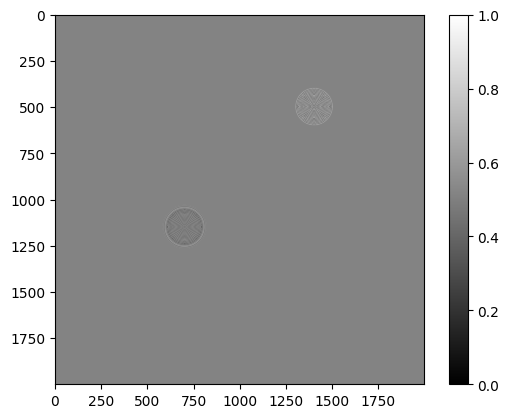

In [21]:
from skimage.restoration import unwrap_phase


res = (2000, 2000)
dxy = 1 #microns per pixel
rad1 = 100 #microns
rad2 = 100 #microns
pos1 = (400, 500) #microns
pos2 = (-300, -150) #microns
distance1 = 0 #This sphere will be in focus
distance2 = 150 #microns back

lambda_ = 0.633

sp1 = phase_sphere(res, rad1, pos1, distance1, 0.633, dxy, 1)
sp2 = phase_sphere(res, rad2, pos2, distance2, 0.633, dxy, 1)

sp12 = sp1+sp2

plt.imshow(normalize(unwrap_phase(np.angle(sp12)), 1), cmap='gray')
plt.colorbar()